# Netflix Collaborative Filter using ItemKNN

# 1. Importing Files

Importing the desired Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# For Surprise library
import surprise
from surprise import KNNBasic, Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise.accuracy import rmse
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# For Matrix Creation
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.spatial.distance import pdist, squareform

# 2. Exploratory Data Analysis

Since, there were 4 combined_data.txt files in txt format. It contains the MovieID, CustomerID, Rating and Date. These python code below combine them and convert them to CSV.

In [ ]:
# Define the function to load combined data files
def load_combined_data(file_path):
    data = []
    movie_id = None
    with open(file_path, 'r') as file:
        for line in file:
            if line.endswith(':\n'):
                movie_id = line.replace(':', '').strip()
            else:
                customer_id, rating, date = line.strip().split(',')
                data.append([movie_id, customer_id, rating, date])
    return pd.DataFrame(data, columns=['MovieID', 'CustomerID', 'Rating', 'Date'])

# List of file paths using raw strings or double backslashes
combined_data_files = [
    'combined_data_1.txt',
    'combined_data_2.txt',
    'combined_data_3.txt',
    'combined_data_4.txt'
]


# Load all combined_data files
all_data_frames = [load_combined_data(file) for file in combined_data_files]

# Concatenate all dataframes into a single dataframe
combined_data_df = pd.concat(all_data_frames, ignore_index=True)

# Display the first few rows of the combined dataframe
print(combined_data_df.head())

# Save the dataframe to a new CSV file
combined_data_df.to_csv('combined_data.csv', index=False)


Sorting the combined_data file based on MovieID

In [17]:
# Sorting the DataFrame based on 'MovieID' in ascending order.
combined_data_df = combined_data_df.sort_values(by='MovieID', ascending=True)

# Resetting the index of the DataFrame after sorting.
combined_data_df = combined_data_df.reset_index(drop=True)

# Now combined_data_df is sorted in ascending order by 'MovieID'.
# You can display the first few rows to confirm.
print(combined_data_df.head())

   MovieID  CustomerID  Rating
0        1     1488844       3
1        1     1605780       4
2        1     2005193       4
3        1     1565175       5
4        1      493945       5


Loading the probe, qualifying and movie titles dataset - 

In [6]:
# Function to load probe data
def load_probe(file_path):
    probe_data = []
    movie_id = None
    with open(file_path, 'r') as file:
        for line in file:
            if line.endswith(':\n'):
                movie_id = line.rstrip(':\n')
            else:
                customer_id = line.strip()
                probe_data.append([movie_id, customer_id])
    probe_df = pd.DataFrame(probe_data, columns=['MovieID', 'CustomerID'])
    return probe_df

# Function to load qualifying data
def load_qualifying(file_path):
    qualifying_data = []
    movie_id = None
    with open(file_path, 'r') as file:
        for line in file:
            if line.endswith(':\n'):
                movie_id = line.rstrip(':\n')
            else:
                customer_id, date = line.strip().split(',')
                qualifying_data.append([movie_id, customer_id, date])
    qualifying_df = pd.DataFrame(qualifying_data, columns=['MovieID', 'CustomerID', 'Date'])
    return qualifying_df

# Function to load movie titles data
def load_movie_titles(file_path):
    # Adjusted as per your input to handle commas in movie titles
    movie_titles_data = []
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            # Split the line only on the first two commas
            parts = line.strip().split(',', 2)
            if len(parts) < 3:
                # Handle any rows that do not have the expected number of fields
                continue
            movie_id, year, title = parts
            movie_titles_data.append([movie_id, year, title])

    movie_titles_df = pd.DataFrame(movie_titles_data, columns=['MovieID', 'YearOfRelease', 'Title'])
    return movie_titles_df

# Load the probe dataset
probe_file_path = 'probe.txt'
probe_df = load_probe(probe_file_path)

# Load the qualifying dataset
qualifying_file_path = 'qualifying.txt'
qualifying_df = load_qualifying(qualifying_file_path)

# Load the movie titles dataset
movie_titles_file_path = 'movie_titles.csv'
movie_titles_df = load_movie_titles(movie_titles_file_path)

# Display the first few rows of each DataFrame
print(probe_df.head())
print(qualifying_df.head())
print(movie_titles_df.head())

  MovieID CustomerID
0       1      30878
1       1    2647871
2       1    1283744
3       1    2488120
4       1     317050
  MovieID CustomerID        Date
0       1    1046323  2005-12-19
1       1    1080030  2005-12-23
2       1    1830096  2005-03-14
3       1     368059  2005-05-26
4       1     802003  2005-11-07
  MovieID YearOfRelease                         Title
0       1          2003               Dinosaur Planet
1       2          2004    Isle of Man TT 2004 Review
2       3          1997                     Character
3       4          1994  Paula Abdul's Get Up & Dance
4       5          2004      The Rise and Fall of ECW


Getting the data overview of all these files i.e. probe, qualifying, movie_titles and combined_data.

In [10]:
# Data Overview

combined_data_df = pd.read_csv('combined_data.csv')
print(probe_df.info())
print(qualifying_df.info())
print(movie_titles_df.info())
print(combined_data_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408395 entries, 0 to 1408394
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1408395 non-null  object
 1   CustomerID  1408395 non-null  object
dtypes: object(2)
memory usage: 21.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817131 entries, 0 to 2817130
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   MovieID     object
 1   CustomerID  object
 2   Date        object
dtypes: object(3)
memory usage: 64.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MovieID        17770 non-null  object
 1   YearOfRelease  17770 non-null  object
 2   Title          17770 non-null  object
dtypes: object(3)
memory usage: 416.6+ KB
None
<class 'pandas.core.frame.

In [11]:
# Summary Statistics
# For the probe and qualifying datasets, we only have user IDs and movie IDs, no numerical data to summarize.
# For movie_titles, we can look at the distribution of the year of release.
print(movie_titles_df['YearOfRelease'].describe())


count     17770
unique       95
top        2004
freq       1436
Name: YearOfRelease, dtype: object


In [12]:
print(combined_data_df['MovieID'].describe())

count    1.004805e+08
mean     9.070915e+03
std      5.131891e+03
min      1.000000e+00
25%      4.677000e+03
50%      9.051000e+03
75%      1.363500e+04
max      1.777000e+04
Name: MovieID, dtype: float64


In [1]:
# Count the number of lines in the CSV
file_path = 'combined_data.csv'
with open(file_path, 'r') as file:
    line_count = sum(1 for line in file)

print(f"The number of lines in the file is: {line_count}")


The number of lines in the file is: 100480508


In [5]:
# Load the dataset
combined_data_df = pd.read_csv('combined_data.csv')

# Basic information about the dataset
print(combined_data_df.info())

# Display the first few entries
print(combined_data_df.head())

# Summary statistics for numerical features
print(combined_data_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   MovieID     int64 
 1   CustomerID  int64 
 2   Rating      int64 
 3   Date        object
dtypes: int64(3), object(1)
memory usage: 3.0+ GB
None
   MovieID  CustomerID  Rating        Date
0        1     1488844       3  2005-09-06
1        1      822109       5  2005-05-13
2        1      885013       4  2005-10-19
3        1       30878       4  2005-12-26
4        1      823519       3  2004-05-03
            MovieID    CustomerID        Rating
count  1.004805e+08  1.004805e+08  1.004805e+08
mean   9.070915e+03  1.322489e+06  3.604290e+00
std    5.131891e+03  7.645368e+05  1.085219e+00
min    1.000000e+00  6.000000e+00  1.000000e+00
25%    4.677000e+03  6.611980e+05  3.000000e+00
50%    9.051000e+03  1.319012e+06  4.000000e+00
75%    1.363500e+04  1.984455e+06  4.000000e+00
max    1.777000e+04  2.649429e+06  5.000000

In [6]:
# Check for missing values
print(combined_data_df.isnull().sum())

MovieID       0
CustomerID    0
Rating        0
Date          0
dtype: int64


In [7]:
# Unique values in each column
for column in combined_data_df.columns:
    print(f"Unique values in {column}: {combined_data_df[column].nunique()}")

# Distribution of ratings
print(combined_data_df['Rating'].value_counts())

Unique values in MovieID: 17770
Unique values in CustomerID: 480189
Unique values in Rating: 5
Unique values in Date: 2182
4    33750958
3    28811247
5    23168232
2    10132080
1     4617990
Name: Rating, dtype: int64


In [8]:
# Convert 'Date' to datetime and check ratings over time
combined_data_df['Date'] = pd.to_datetime(combined_data_df['Date'])
ratings_over_time = combined_data_df.groupby(combined_data_df['Date'].dt.year)['Rating'].count()
print(ratings_over_time)

Date
1999        2178
2000      924443
2001     1769031
2002     4342871
2003     9985337
2004    30206574
2005    53250073
Name: Rating, dtype: int64


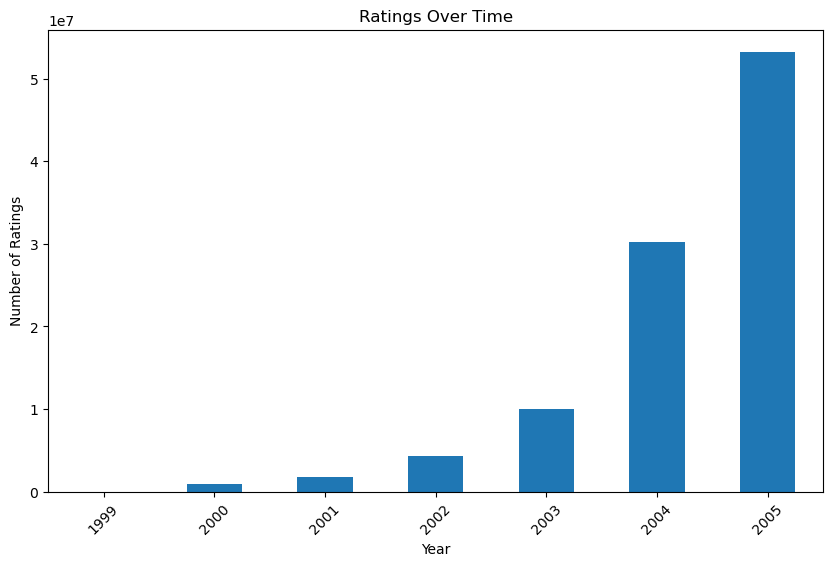

In [11]:
# Plotting ratings over time
plt.figure(figsize=(10, 6))
ratings_over_time.plot(kind='bar')
plt.title('Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()


# 3. Performing Collaborative Filter using Item-based rating prediction

There are 2 methods to do create Item based KNN both are covered below :
- 3.1 : Using Surprise Library
- 3.2 : Using Matrix Creation

## 3.1. Using Surprise Library

There are 3 ways to calculate similarity using surprise library all of them are covered below :
- a) Cosine Similarity
- b) MSD Similarity (Mean Squared Difference)
- c) Pearson Correlation Similarity

### 3.1.1. Cosine Similarity

In [1]:
try:
    import surprise
    print("scikit-surprise is installed and ready!")
except ImportError:
    print("scikit-surprise is not installed.")

scikit-surprise is installed and ready!


In [1]:
from surprise import KNNBasic, Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
import pandas as pd
import numpy as np

# Load the Data
combined_data_df = pd.read_csv('combined_data.csv')
sample_data = combined_data_df[combined_data_df['MovieID']]

# Setup data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sample_data[['CustomerID', 'MovieID', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

# Initialize the algorithm
sim_options = {
    'name': 'cosine',
    'user_based': False  # Item-based similarity
}
algo = KNNBasic(sim_options=sim_options)

# Train and predict
algo.fit(trainset)
predictions = algo.test(testset)

# Calculate RMSE
rmse_val = rmse(predictions)

# Manually calculate MSE
mse_val = np.mean([float((pred.est - pred.r_ui) ** 2) for pred in predictions])

print(f"RMSE: {rmse_val}")
print(f"MSE: {mse_val}")

RMSE: 1.0298
RMSE: 1.029845675445635
MSE: 1.017623683297236


Summary - This code uses Suprise to first get the cosine similarity matrix. It uses the cosine similarity matrix to calculate the RMSE and MSE.

Since, the above code was taking a lot of time. We will convert the combined_data file to parquet and try different method of similarity. 

### 3.1.2. MSD Similarity (Mean Squared Difference)

This code creates MSD Similarity Matrix instead of Cosine as used above.

In [9]:

# Load the dataset
combined_data_df = pd.read_parquet('combined_data.parquet')

# Assuming combined_data_df has columns ['CustomerID', 'MovieID', 'Rating']
# Setup the reader with the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset into Surprise's format from the DataFrame
data = Dataset.load_from_df(combined_data_df[['CustomerID', 'MovieID', 'Rating']], reader)

 # Split the data into training and test set (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.20)

# Define the algorithm with item-based configuration
sim_options = {
    'name': 'msd',  # Using MSD 
    'user_based': False  # Item-based CF
}

algo = KNNBasic(sim_options=sim_options)

# Train the algorithm
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Calculate and print RMSE
rmse_val = rmse(predictions)

# Manually calculate and print MSE
mse_val = np.mean([(pred.est - pred.r_ui) ** 2 for pred in predictions])
print(f"RMSE: {rmse_val}")
print(f"MSE: {mse_val}")


RMSE: 0.9401
RMSE: 0.9401110421321236
MSE: 0.8838087715387475


Summary - This code uses Suprise to first get MSD similarity matrix. It uses the cosine similarity matrix to calculate the RMSE and MSE. We can also see that RMSE and MSE have dropped singificantly compared to cosine similarity.

### 3.1.3. Pearson Correlation Similarity

Now we will use Pearson Correlation as a measure of similarity. 

In [13]:

# Load the dataset
combined_data_df = pd.read_parquet('combined_data.parquet')

# Assuming combined_data_df has columns ['CustomerID', 'MovieID', 'Rating']
# Setup the reader with the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset into Surprise's format from the DataFrame
data = Dataset.load_from_df(combined_data_df[['CustomerID', 'MovieID', 'Rating']], reader)

# Split the data into training and test set (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.20)

# Define the algorithm with item-based configuration
sim_options = {
    'name': 'pearson',  # Using pearson correlation
    'user_based': False  # Item-based CF
}

algo = KNNBasic(sim_options=sim_options)

# Train the algorithm
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Calculate and print RMSE
rmse_val = rmse(predictions)

# Manually calculate and print MSE
mse_val = np.mean([(pred.est - pred.r_ui) ** 2 for pred in predictions])
print(f"RMSE: {rmse_val}")
print(f"MSE: {mse_val}")


RMSE: 0.9601
RMSE: 0.9601358401433122
MSE: 0.921860831527704


Summary - This code uses Suprise to first get Pearson Correlation matrix. It uses the Pearson Correlation matrix to calculate the RMSE and MSE. We can also see that RMSE and MSE have is less than Cosine SImilarity method and greater then MSD method.

## 3.2. Using Matrix Creation

#### 3.2.1. Creating Sparcity Matrix

Let us start by creating Sparcity matrix. Sparcity matrix contains CustomerID in first column and MovieID as the Header of each row with Ratings in the middle. For ItemKNN, matrix will be transformed eventually.

In [6]:
# Load the dataset
combined_data_df = pd.read_csv('combined_data.csv', usecols=['MovieID', 'CustomerID', 'Rating'])

In [7]:
# Map MovieID and CustomerID to unique integer indices
movie_mapper = {movie_id: i for i, movie_id in enumerate(combined_data_df['MovieID'].unique())}
customer_mapper = {customer_id: i for i, customer_id in enumerate(combined_data_df['CustomerID'].unique())}

# Map the MovieIDs and CustomerIDs to their respective indices
combined_data_df['MovieIdx'] = combined_data_df['MovieID'].map(movie_mapper)
combined_data_df['CustomerIdx'] = combined_data_df['CustomerID'].map(customer_mapper)

# Create the sparse matrix
sparse_matrix = csr_matrix(
    (combined_data_df['Rating'], (combined_data_df['CustomerIdx'], combined_data_df['MovieIdx'])),
    shape=(len(customer_mapper), len(movie_mapper))
)


Lets plot the Rating matrix to visualize its sparcity. 

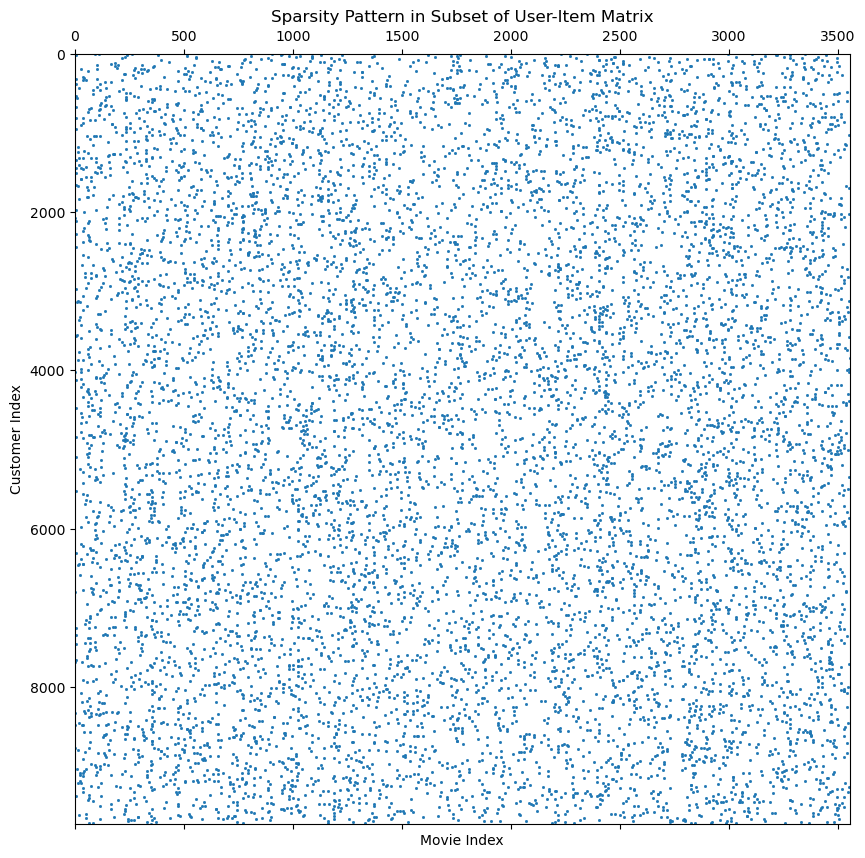

In [10]:
# Assuming combined_data_df is already loaded and has 'MovieID', 'CustomerID', and 'Rating' columns
# For demonstration, let's work with a smaller subset of the data to make the visualization clearer
subset_data = combined_data_df.sample(n=10000, random_state=42)

# Create a mapping for MovieID and CustomerID to integer indices
movie_idx = {movie: idx for idx, movie in enumerate(np.unique(subset_data['MovieID']))}
customer_idx = {customer: idx for idx, customer in enumerate(np.unique(subset_data['CustomerID']))}

# Apply mapping
subset_data['MovieIdx'] = subset_data['MovieID'].map(movie_idx)
subset_data['CustomerIdx'] = subset_data['CustomerID'].map(customer_idx)

# Create the sparse matrix
rows = subset_data['CustomerIdx']
cols = subset_data['MovieIdx']
ratings = subset_data['Rating']

sparse_matrix = csr_matrix((ratings, (rows, cols)), shape=(len(customer_idx), len(movie_idx)))

# Visualize a portion of the sparse matrix
plt.figure(figsize=(10, 10))
plt.spy(sparse_matrix, markersize=1, aspect='auto')
plt.title('Sparsity Pattern in Subset of User-Item Matrix')
plt.xlabel('Movie Index')
plt.ylabel('Customer Index')
plt.show()


Checking the Shape, Percentage of blank values and Number of possible and actual interactions of the matrix.

In [21]:
print(f"Shape of the Sparse Interaction Matrix: {sparse_matrix.shape}")
print(f"Number of possible interactions: {sparse_matrix.shape[0] * sparse_matrix.shape[1]}")
print(f"Number of actual interactions: {sparse_matrix.nnz}")
print(f"Sparsity of the Matrix: {(1 - sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1])) * 100:.2f}%")

Shape of the Sparse Interaction Matrix: (480189, 17770)
Number of possible interactions: 8532958530
Number of actual interactions: 100480507
Sparsity of the Matrix: 98.82%


### 3.2.2. Creating Movie Similarity Matrix

Splitting the data.
Calculate Item-Item Similarities
Convert to Sparse Matrix: If not already, convert your DataFrame to a sparse matrix format to efficiently compute similarities.
Compute Similarities: Use cosine similarity to calculate the item-item similarity matrix. Libraries like scikit-learn provide functions like cosine_similarity that can be used directly on sparse matrices.

In [3]:
# Load the CSV file
df = pd.read_csv('combined_data.csv', usecols=['MovieID', 'CustomerID', 'Rating'])

# Sample 5% of the data
sampled_df = df.sample(frac=0.001, random_state=42)

# Now, split the sampled data into train, validate, and test sets
# Let's use 70% for train, 15% for validation, and 15% for test.
train_df, temp_df = train_test_split(sampled_df, test_size=0.3, random_state=42)  # 30% for temp, which is 15% for validation and 15% for test from the total
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split the temp evenly into validation and test

# Save the split datasets to new CSV files
train_df.to_csv('train.csv', index=False)
validate_df.to_csv('validate.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Data has been split into train, validate, and test sets and saved as CSV files.")


Data has been split into train, validate, and test sets and saved as CSV files.


Creating Rating matrix from the train split 

In [50]:

# Load the datasets
train_df = pd.read_csv('train.csv', usecols=['MovieID', 'CustomerID', 'Rating'])
validate_df = pd.read_csv('validate.csv', usecols=['MovieID', 'CustomerID', 'Rating'])
test_df = pd.read_csv('test.csv', usecols=['MovieID', 'CustomerID', 'Rating'])

# Combine the datasets
combined_df = pd.concat([train_df, validate_df, test_df])

# Pivot the combined DataFrame to create the matrix
# Set MovieID as the index, CustomerID as the columns, and fill with Ratings
matrix_df = combined_df.pivot_table(index='MovieID', columns='CustomerID', values='Rating', aggfunc='mean')

# Save the matrix to a new CSV file
matrix_df.to_csv('movie_customer_rating_matrix.csv')
print("Matrix saved to movie_customer_rating_matrix.csv.")

Matrix saved to movie_customer_rating_matrix.csv.


In [1]:

# Load the CSV file
# Ensure you replace 'path_to_your_file.csv' with the actual path to the CSV file.
df = pd.read_csv('train.csv', usecols=['MovieID', 'CustomerID', 'Rating'])

# Pivot the DataFrame to create the matrix
# Set MovieID as the index, CustomerID as the columns, and fill with Ratings
matrix_df = df.pivot_table(index='MovieID', columns='CustomerID', values='Rating')

# Save the matrix to a new CSV file
matrix_df.to_csv('movie_customer_rating_matrix.csv')

print("Matrix saved to movie_customer_rating_matrix.csv.")

Matrix saved to movie_customer_rating_matrix.csv.


Checking the values of Rating Matrix

In [2]:
df = pd.read_csv('movie_customer_rating_matrix.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Columns: 22370 entries, MovieID to 2649335
dtypes: float64(22369), int64(1)
memory usage: 391.3 MB


In [3]:
df.head()

,MovieID,546,735,989,1188,1442,1701,1702,1715,1809,...,2648260,2648582,2648589,2648694,2649033,2649049,2649057,2649059,2649225,2649335
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creating Cosine Similarity Matrix

In [4]:
# Load the CSV file
# Ensure you replace 'path_to_your_file.csv' with the actual path to the CSV file.
df = pd.read_csv('movie_customer_rating_matrix.csv', index_col='MovieID')

# Fill missing values with 0s
df.fillna(0, inplace=True)

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(df)

# Convert the cosine similarity matrix into a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df.index, columns=df.index)

# Save the cosine similarity matrix to a new CSV file
cosine_sim_df.to_csv('movie_cosine_similarity_matrix.csv')

print("Cosine similarity matrix saved to movie_cosine_similarity_matrix.csv.")


Cosine similarity matrix saved to movie_cosine_similarity_matrix.csv.


Viewing Movie-Movie Cosine Similarity Matrix

In [5]:
df_cosine_similarity = pd.read_csv('movie_cosine_similarity_matrix.csv')
df_cosine_similarity.head()

,MovieID,1,5,8,11,16,17,18,22,25,...,4486,4488,4489,4490,4491,4492,4493,4495,4496,4497
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Parameter about Movie-Movie Cosine Similarity Matrix

In [6]:
df_cosine_similarity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Columns: 2294 entries, MovieID to 4497
dtypes: float64(2293), int64(1)
memory usage: 40.1 MB


Creating Movie-Movie Manhattan Distance Matrix

In [7]:

# Load the CSV file
# Ensure you replace 'path_to_your_file.csv' with the actual path to the CSV file.
df = pd.read_csv('movie_customer_rating_matrix.csv', index_col='MovieID')

# Fill missing values with 0s, as Manhattan distance requires numerical values
df.fillna(0, inplace=True)

# Calculate the pairwise Manhattan distances between the MovieIDs
manhattan_distances = pdist(df.values, metric='cityblock')

# Convert the condensed distance matrix to a square matrix
manhattan_distance_matrix = squareform(manhattan_distances)

# Convert the distance matrix into a DataFrame
manhattan_df = pd.DataFrame(manhattan_distance_matrix, index=df.index, columns=df.index)

# Save the Manhattan distance matrix to a new CSV file
manhattan_df.to_csv('movie_manhattan_distance_matrix.csv')

print("Manhattan distance matrix saved to movie_manhattan_distance_matrix.csv.")


Manhattan distance matrix saved to movie_manhattan_distance_matrix.csv.


Viewing Movie-Movie Manhattan Distance Matrix

In [8]:
df_manhattan = pd.read_csv('movie_manhattan_distance_matrix.csv')
df_manhattan.head()

,MovieID,1,5,8,11,16,17,18,22,25,...,4486,4488,4489,4490,4491,4492,4493,4495,4496,4497
0,1,0.0,9.0,34.0,4.0,16.0,12.0,28.0,4.0,4.0,...,3.0,147.0,7.0,21.0,5.0,35.0,26.0,6.0,35.0,5.0
1,5,9.0,0.0,39.0,9.0,21.0,17.0,33.0,9.0,9.0,...,8.0,152.0,12.0,26.0,10.0,40.0,31.0,11.0,40.0,10.0
2,8,34.0,39.0,0.0,34.0,46.0,42.0,58.0,34.0,34.0,...,33.0,177.0,37.0,51.0,35.0,65.0,56.0,36.0,65.0,35.0
3,11,4.0,9.0,34.0,0.0,16.0,12.0,28.0,4.0,4.0,...,3.0,147.0,7.0,21.0,5.0,35.0,26.0,6.0,35.0,5.0
4,16,16.0,21.0,46.0,16.0,0.0,24.0,40.0,16.0,16.0,...,15.0,159.0,19.0,33.0,17.0,47.0,38.0,18.0,47.0,17.0


Parameter about Movie-Movie Manhattan Distnace Matrix

In [9]:
df_manhattan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Columns: 2294 entries, MovieID to 4497
dtypes: float64(2293), int64(1)
memory usage: 40.1 MB


Transforming Validate and Test Datasets

In [5]:
# Function to transform the dataset
def transform_dataset(input_csv_path, output_csv_path):
    # Load the dataset
    df = pd.read_csv(input_csv_path)
    
    # Pivot the DataFrame to get the desired format
    transformed_df = df.pivot_table(index='MovieID', columns='CustomerID', values='Rating', fill_value=0)
    
    # Reset index to bring MovieID back as a column
    transformed_df.reset_index(inplace=True)
    
    # Save the transformed DataFrame to a new CSV file
    transformed_df.to_csv(output_csv_path, index=False)
    print(f"Transformed dataset saved to {output_csv_path}")

# Paths to the input files
validate_csv_path = 'validate.csv'
test_csv_path = 'test.csv'

# Paths to the output files
validate_output_path = 'transformed_validate.csv'
test_output_path = 'transformed_test.csv'

# Transform validate.csv and test.csv
transform_dataset(validate_csv_path, validate_output_path)
transform_dataset(test_csv_path, test_output_path)


Transformed dataset saved to transformed_validate.csv
Transformed dataset saved to transformed_test.csv


### 3.2.3. Prediction

A) Cosine Similarity

In [4]:
# Load the cosine similarity matrix for movies
cosine_similarity_df = pd.read_csv('movie_cosine_similarity_matrix.csv', index_col='MovieID')

# Load the validation data
validate_df = pd.read_csv('validate.csv')

# Load the movie-customer rating matrix
rating_matrix_df = pd.read_csv('movie_customer_rating_matrix.csv').set_index('MovieID')

# Predict the rating using the cosine similarity matrix
def predict_rating(movie_id, customer_id, k, similarity_df, rating_matrix):
    # Check if the movie_id exists in the similarity matrix
    if movie_id not in similarity_df.index:
        # If the movie_id does not exist, skip the prediction
        return np.nan
    
    # Check if the customer_id exists in the rating matrix
    if customer_id not in rating_matrix.columns:
        # If the customer_id does not exist, use the average customer rating as prediction
        return rating_matrix.mean(axis=0).get(customer_id, np.nan)
    
    # Retrieve the k most similar movies, excluding the movie itself
    most_similar_movies = similarity_df.loc[movie_id].nlargest(k+1)[1:]
    
    # Get the ratings that this customer has given to the most similar movies
    customer_ratings = rating_matrix.loc[most_similar_movies.index, customer_id]
    
    # Calculate the predicted rating as a weighted average of the ratings of the most similar movies
    if not customer_ratings.empty:
        weighted_sum = np.dot(customer_ratings.fillna(0), most_similar_movies)
        norm = most_similar_movies.loc[customer_ratings.index].sum()
        return weighted_sum / norm if norm != 0 else np.nan
    else:
        # No similar movies have been rated by the customer
        # Use the average rating of all rated movies by this customer
        return rating_matrix.mean(axis=0).get(customer_id, np.nan)

# Define k for the top k most similar movies to consider for the prediction
k = 30

# Apply the predict_rating function to each row in the validation DataFrame
validate_df['PredictedRating'] = validate_df.apply(
    lambda x: predict_rating(x['MovieID'], x['CustomerID'], k, cosine_similarity_df, rating_matrix_df),
    axis=1
)

# Calculate the RMSE and MSE, ignoring NaN values in predictions
validate_df.dropna(subset=['PredictedRating'], inplace=True)  # Remove rows with NaN predictions
mse = mean_squared_error(validate_df['Rating'], validate_df['PredictedRating'])
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")


RMSE: 1.5878814569631832
MSE: 2.5213675213675213


B) Manhattan Distance

In [11]:
# Load the cosine similarity matrix for movies
movie_similarity_df = pd.read_csv('movie_manhattan_distance_matrix.csv', index_col='MovieID')

# Load the validation data
validate_df = pd.read_csv('validate.csv')

# Load the movie-customer rating matrix
rating_matrix_df = pd.read_csv('movie_customer_rating_matrix.csv').set_index('MovieID')

# Predict the rating using the cosine similarity matrix
def predict_rating(movie_id, customer_id, k, similarity_df, rating_matrix):
    # If the movie_id or customer_id is not found, use a default score
    # Here we'll use the average rating of all movies or the average rating given by the customer
    if movie_id not in similarity_df.index or customer_id not in rating_matrix.columns:
        if movie_id not in similarity_df.index and customer_id in rating_matrix.columns:
            # Customer exists, movie does not. Use the customer's average rating.
            return rating_matrix.loc[:, customer_id].mean()
        elif customer_id not in rating_matrix.columns and movie_id in similarity_df.index:
            # Movie exists, customer does not. Use the movie's average rating.
            return rating_matrix.loc[movie_id, :].mean()
        else:
            # Neither movie nor customer exists. Use the global average.
            return rating_matrix.stack().mean()
    
    # Retrieve the k most similar movies, excluding the movie itself
    similar_movies = similarity_df.loc[movie_id].sort_values(ascending=False)[1:k+1]
    
    # Get the ratings that this customer has given to the similar movies
    customer_ratings = rating_matrix.loc[similar_movies.index, customer_id]
    
    # Handle cases where similar movies might not have been rated by the customer
    customer_ratings = customer_ratings.fillna(0)
    similar_movies = similar_movies * (customer_ratings > 0).astype(int)
    
    # Calculate the predicted rating as a weighted average
    if similar_movies.sum() > 0:
        weighted_ratings = customer_ratings * similar_movies
        return weighted_ratings.sum() / similar_movies.sum()
    else:
        # No similar movies have been rated by the customer
        # Use the average rating of all rated movies by this customer
        return rating_matrix.loc[:, customer_id].mean() if customer_id in rating_matrix.columns else rating_matrix.stack().mean()

# Define k for the top k most similar movies to consider for the prediction
k = 30

# Apply the predict_rating function to each row in the validation DataFrame
validate_df['PredictedRating'] = validate_df.apply(
    lambda x: predict_rating(x['MovieID'], x['CustomerID'], k, movie_similarity_df, rating_matrix_df),
    axis=1
)

# Calculate the RMSE and MSE, ignoring NaN values in predictions
validate_df.dropna(subset=['PredictedRating'], inplace=True)  # Remove rows with NaN predictions
mse = mean_squared_error(validate_df['Rating'], validate_df['PredictedRating'])
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")



RMSE: 1.0686170483490132
MSE: 1.141942396022157


C) Hyperparameter Tuning

Using Cosine Similarity Matrix

In [55]:
def load_and_prepare_matrices(cosine_similarity_file, rating_matrix_file):
    # Load and prepare the cosine similarity matrix
    cosine_similarity_df = pd.read_csv(cosine_similarity_file, index_col=0)
    cosine_similarity_df.columns = cosine_similarity_df.columns.astype(int)  # Ensure MovieIDs as columns are integers
    
    # Load and prepare the movie-customer rating matrix
    rating_matrix_df = pd.read_csv(rating_matrix_file, index_col=0)
    rating_matrix_df.columns = rating_matrix_df.columns.astype(int)  # Ensure CustomerIDs as columns are integers
    
    return cosine_similarity_df, rating_matrix_df

def predict_rating_item_cosine(movie_id, customer_id, k, movie_similarity_df, item_customer_matrix):
    if movie_id not in movie_similarity_df.index or customer_id not in item_customer_matrix.columns:
        return np.nan  # Cannot predict if either movie or customer is not found

    # Retrieve the k most similar movies to the given movie_id
    top_k_similarities = movie_similarity_df.loc[movie_id].nlargest(k+1)[1:]  # Exclude self similarity
    
    # Filter to get only those top k movies that the customer has rated
    rated_by_customer = item_customer_matrix.loc[top_k_similarities.index, customer_id].dropna()
    
    # Retrieve corresponding similarities
    similarities = top_k_similarities.loc[rated_by_customer.index]
    
    if similarities.empty:
        return np.nan  # Cannot predict if there are no similar movies rated by the customer
    
    # Compute the weighted average rating
    weighted_sum = np.dot(rated_by_customer, similarities)
    prediction = weighted_sum / similarities.sum()

    return prediction





In [6]:
def evaluate_predictions(k_values, transformed_validate_file, cosine_similarity_df, rating_matrix_df):
    results = []

    transformed_validate_df = pd.read_csv(transformed_validate_file, index_col=0)
    transformed_validate_df.columns = transformed_validate_df.columns.astype(int)  # Ensure CustomerIDs as columns are integers

    for k in k_values:
        actual = []
        predicted = []

        for movie_id in transformed_validate_df.index:
            for customer_id in transformed_validate_df.columns:
                actual_rating = transformed_validate_df.at[movie_id, customer_id]
                if pd.notna(actual_rating):
                    pred_rating = predict_rating_item_cosine(movie_id, customer_id, k, cosine_similarity_df, rating_matrix_df)
                    if pd.notna(pred_rating):
                        actual.append(actual_rating)
                        predicted.append(pred_rating)
        
        mse = mean_squared_error(actual, predicted)
        rmse = sqrt(mse)

        results.append({'k': k, 'RMSE': rmse, 'MSE': mse})

    return results

# Example usage:
# Ensure to load the matrices correctly using load_and_prepare_matrices function
cosine_similarity_df, rating_matrix_df = load_and_prepare_matrices('movie_cosine_similarity_matrix.csv', 'movie_customer_rating_matrix.csv')
k_values = [40, 50, 60]
evaluation_results = evaluate_predictions(k_values, 'transformed_validate.csv', cosine_similarity_df, rating_matrix_df)

for result in evaluation_results:
    print(f"k={result['k']}, RMSE={result['RMSE']:.4f}, MSE={result['MSE']:.4f}")


k=40, RMSE=1.5878, MSE=2.5213
k=50, RMSE=1.6365, MSE=2.6215
k=60, RMSE=1.7345, MSE=2.6937


Using Manhattan Distance Matrix

In [1]:
def load_and_prepare_matrices(manhattan_distance_file, rating_matrix_file):
    # Load and prepare the Manhattan distance matrix
    manhattan_distance_df = pd.read_csv(manhattan_distance_file, index_col=0)
    manhattan_distance_df.columns = manhattan_distance_df.columns.astype(int)  # Ensure MovieIDs as columns are integers
    
    # Load and prepare the movie-customer rating matrix
    rating_matrix_df = pd.read_csv(rating_matrix_file, index_col=0)
    rating_matrix_df.columns = rating_matrix_df.columns.astype(int)  # Ensure CustomerIDs as columns are integers
    
    return manhattan_distance_df, rating_matrix_df

def predict_rating_item_manhattan(movie_id, customer_id, k, movie_distance_df, item_customer_matrix):
    if movie_id not in movie_distance_df.index or customer_id not in item_customer_matrix.columns:
        return np.nan  # Cannot predict if either movie or customer is not found

    # Retrieve the k closest movies to the given movie_id according to Manhattan distance
    closest_k_movies = movie_distance_df.loc[movie_id].nsmallest(k+1)[1:]  # Exclude self distance
    
    # Filter to get only those top k movies that the customer has rated
    rated_by_customer = item_customer_matrix.loc[closest_k_movies.index, customer_id].dropna()
    
    # Retrieve corresponding distances
    distances = closest_k_movies.loc[rated_by_customer.index]
    
    if distances.empty:
        return np.nan  # Cannot predict if there are no similar movies rated by the customer
    
    # Compute the weighted average rating, inverting the distance as weights since closer distance means higher similarity
    weighted_sum = np.dot(rated_by_customer, 1/distances)
    prediction = weighted_sum / (1/distances).sum()

    return prediction


In [4]:
def evaluate_predictions(k_values, transformed_validate_file, manhattan_distance_df, rating_matrix_df, sample_frac=0.001):
    results = []

    # Load and sample a fraction of the transformed validation data for faster execution
    transformed_validate_df = pd.read_csv(transformed_validate_file, index_col=0)
    transformed_validate_df.columns = transformed_validate_df.columns.astype(int)  # Ensure CustomerIDs as columns are integers
    # Sample a fraction of the MovieIDs for quicker processing
    sampled_transformed_validate_df = transformed_validate_df.sample(frac=sample_frac, random_state=42)
    
    for k in k_values:
        actual = []
        predicted = []

        for movie_id in sampled_transformed_validate_df.index:
            for customer_id in sampled_transformed_validate_df.columns:
                actual_rating = sampled_transformed_validate_df.at[movie_id, customer_id]
                if pd.notna(actual_rating):
                    pred_rating = predict_rating_item_manhattan(movie_id, customer_id, k, manhattan_distance_df, rating_matrix_df)
                    if pd.notna(pred_rating):
                        actual.append(actual_rating)
                        predicted.append(pred_rating)
        
        mse = mean_squared_error(actual, predicted)
        rmse = sqrt(mse)

        results.append({'k': k, 'RMSE': rmse, 'MSE': mse})

    return results

# Example usage with sampling for faster evaluation
manhattan_distance_df, rating_matrix_df = load_and_prepare_matrices('movie_manhattan_distance_matrix.csv', 'movie_customer_rating_matrix.csv')
k_values = [40, 50, 60]
evaluation_results = evaluate_predictions(k_values, 'transformed_validate.csv', manhattan_distance_df, rating_matrix_df, sample_frac=0.1)

for result in evaluation_results:
    print(f"k={result['k']}, RMSE={result['RMSE']:.4f}, MSE={result['MSE']:.4f}")

k=40, RMSE=1.1419, MSE=1.0686
k=50, RMSE=1.2348, MSE=1.1478
k=60, RMSE=1.6732, MSE=1.7863


### 3.2.4. Testing the best model using test dataset

Manhattan Distance was the best method so far. The Best value of K after Hyperparameter tuning was 40. So, lets use it to get our final results on test dataset.

In [20]:
# Load the cosine similarity matrix for movies
movie_similarity_df = pd.read_csv('movie_manhattan_distance_matrix.csv', index_col='MovieID')

# Load the validation data
validate_df = pd.read_csv('test.csv')

# Load the movie-customer rating matrix
rating_matrix_df = pd.read_csv('movie_customer_rating_matrix.csv').set_index('MovieID')

# Predict the rating using the cosine similarity matrix
def predict_rating(movie_id, customer_id, k, similarity_df, rating_matrix):
    # If the movie_id or customer_id is not found, use a default score
    # Here we'll use the average rating of all movies or the average rating given by the customer
    if movie_id not in similarity_df.index or customer_id not in rating_matrix.columns:
        if movie_id not in similarity_df.index and customer_id in rating_matrix.columns:
            # Customer exists, movie does not. Use the customer's average rating.
            return rating_matrix.loc[:, customer_id].mean()
        elif customer_id not in rating_matrix.columns and movie_id in similarity_df.index:
            # Movie exists, customer does not. Use the movie's average rating.
            return rating_matrix.loc[movie_id, :].mean()
        else:
            # Neither movie nor customer exists. Use the global average.
            return rating_matrix.stack().mean()
    
    # Retrieve the k most similar movies, excluding the movie itself
    similar_movies = similarity_df.loc[movie_id].sort_values(ascending=False)[1:k+1]
    
    # Get the ratings that this customer has given to the similar movies
    customer_ratings = rating_matrix.loc[similar_movies.index, customer_id]
    
    # Handle cases where similar movies might not have been rated by the customer
    customer_ratings = customer_ratings.fillna(0)
    similar_movies = similar_movies * (customer_ratings > 0).astype(int)
    
    # Calculate the predicted rating as a weighted average
    if similar_movies.sum() > 0:
        weighted_ratings = customer_ratings * similar_movies
        return weighted_ratings.sum() / similar_movies.sum()
    else:
        # No similar movies have been rated by the customer
        # Use the average rating of all rated movies by this customer
        return rating_matrix.loc[:, customer_id].mean() if customer_id in rating_matrix.columns else rating_matrix.stack().mean()

# Define k for the top k most similar movies to consider for the prediction
k = 40

# Apply the predict_rating function to each row in the validation DataFrame
validate_df['PredictedRating'] = validate_df.apply(
    lambda x: predict_rating(x['MovieID'], x['CustomerID'], k, movie_similarity_df, rating_matrix_df),
    axis=1
)

# Calculate the RMSE and MSE, ignoring NaN values in predictions
validate_df.dropna(subset=['PredictedRating'], inplace=True)  # Remove rows with NaN predictions
mse = mean_squared_error(validate_df['Rating'], validate_df['PredictedRating'])
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")


RMSE: 1.0810471239167976
MSE: 1.1686628841287798


# 4. Item-based classification (ItemKNN)

### 4.1. Preparing the Database

In [83]:
# Load the CSV file
df = pd.read_csv('combined_data.csv', usecols=['MovieID', 'CustomerID', 'Rating'])

# Calculate the count of ratings for each movie
rating_counts = df['MovieID'].value_counts()

# Determine the top 5% movies in terms of rating counts
top_5_percent_threshold = rating_counts.quantile(0.99)
top_movies = rating_counts[rating_counts >= top_5_percent_threshold].index

# Filter the original DataFrame to include only movies in the top 5%
filtered_df = df[df['MovieID'].isin(top_movies)]

# Sample 5% of the filtered data
sampled_df = filtered_df.sample(frac=0.05, random_state=42)

# Now, split the sampled data into train, validate, and test sets
# Let's use 70% for train, 15% for validation, and 15% for test.
train_df, temp_df = train_test_split(sampled_df, test_size=0.3, random_state=42)  # 30% for temp, which is 15% for validation and 15% for test from the total
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split the temp evenly into validation and test

# Save the split datasets to new CSV files
train_df.to_csv('train_v2.csv', index=False)
validate_df.to_csv('validate_v2.csv', index=False)
test_df.to_csv('test_v2.csv', index=False)

print("Data has been split into train, validate, and test sets for the top 1% movies and saved as CSV files.")


Data has been split into train, validate, and test sets for the top 1% movies and saved as CSV files.


In [84]:
train_df.head()

,MovieID,CustomerID,Rating
21079021,3938,2415114,3
12840165,2452,1374373,5
20022628,3825,257021,3
23782971,4432,2014748,4
17949682,3427,204994,4


In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194703 entries, 21079021 to 20727947
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   MovieID     194703 non-null  int64
 1   CustomerID  194703 non-null  int64
 2   Rating      194703 non-null  int64
dtypes: int64(3)
memory usage: 5.9 MB


In [86]:
validate_df.head()

,MovieID,CustomerID,Rating
5505313,1110,313156,4
5543522,1110,1415977,4
3115236,571,2458006,5
19673087,3756,1729454,2
6285686,1220,2622045,3


In [87]:
validate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41722 entries, 5505313 to 23726844
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   MovieID     41722 non-null  int64
 1   CustomerID  41722 non-null  int64
 2   Rating      41722 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [88]:
test_df.head()

,MovieID,CustomerID,Rating
19682677,3756,2331649,3
15141256,2913,2171668,5
16983366,3282,1843962,1
21830515,4123,2199466,1
14415492,2782,2239881,5


In [89]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41723 entries, 19682677 to 20071419
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   MovieID     41723 non-null  int64
 1   CustomerID  41723 non-null  int64
 2   Rating      41723 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [94]:
# Load the CSV file
# Ensure you replace 'path_to_your_file.csv' with the actual path to the CSV file.
df = pd.read_csv('validate_v2.csv', usecols=['MovieID', 'CustomerID', 'Rating'])

# Pivot the DataFrame to create the matrix
# Set MovieID as the index, CustomerID as the columns, and fill with Ratings
matrix_df = df.pivot_table(index='MovieID', columns='CustomerID', values='Rating')

# Save the matrix to a new CSV file
matrix_df.to_csv('validate_matrixv2.csv')

print("Matrix saved to validate_matrixv2.csv.")

Matrix saved to validate_matrixv2.csv.


#### 4.2.1. Creating rating Matrix

In [90]:
# Load the CSV file
# Ensure you replace 'path_to_your_file.csv' with the actual path to the CSV file.
df = pd.read_csv('train_v2.csv', usecols=['MovieID', 'CustomerID', 'Rating'])

# Pivot the DataFrame to create the matrix
# Set MovieID as the index, CustomerID as the columns, and fill with Ratings
matrix_df = df.pivot_table(index='MovieID', columns='CustomerID', values='Rating')

# Save the matrix to a new CSV file
matrix_df.to_csv('movie_customer_rating_matrixv2.csv')

print("Matrix saved to movie_customer_rating_matrixv2.csv.")

Matrix saved to movie_customer_rating_matrixv2.csv.


In [91]:
matrix_df.head()

CustomerID,7,59,87,97,116,130,188,189,199,231,...,2649288,2649296,2649308,2649311,2649328,2649335,2649370,2649378,2649426,2649429
MovieID,,,,,,,,,,,,,,,,,,,,,
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
matrix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 30 to 4472
Columns: 140583 entries, 7 to 2649429
dtypes: float64(140583)
memory usage: 48.3 MB


#### 4.2.2. Creating Manhattan Distance Matrix

In [113]:
# Load the CSV file
# Ensure you replace 'path_to_your_file.csv' with the actual path to the CSV file.
df = pd.read_csv('movie_customer_rating_matrixv2.csv', index_col='MovieID')

# Fill missing values with 0s, as Manhattan distance requires numerical values
df.fillna(0, inplace=True)

# Calculate the pairwise Manhattan distances between the MovieIDs
manhattan_distances = pdist(df.values, metric='cityblock')

# Convert the condensed distance matrix to a square matrix
manhattan_distance_matrix = squareform(manhattan_distances)

# Convert the distance matrix into a DataFrame
manhattan_df = pd.DataFrame(manhattan_distance_matrix, index=df.index, columns=df.index)

# Save the Manhattan distance matrix to a new CSV file
manhattan_df.to_csv('movie_manhattan_distance_matrixv2.csv')

print("Manhattan distance matrix saved to movie_manhattan_distance_matrixv2.csv.")


Manhattan distance matrix saved to movie_manhattan_distance_matrixv2.csv.


In [114]:
manhattan_df.head()

MovieID,30,191,313,457,571,607,758,886,1110,1145,...,3860,3917,3925,3938,3962,4123,4306,4356,4432,4472
MovieID,,,,,,,,,,,,,,,,,,,,,
30,0.0,28338.0,27890.0,30894.0,36597.0,27413.0,27818.0,31182.0,29359.0,30285.0,...,33919.0,28067.0,28152.0,36885.0,36430.0,29656.0,37760.0,28340.0,35669.0,28057.0
191,28338.0,0.0,26130.0,28908.0,34805.0,25447.0,26080.0,29282.0,27515.0,28487.0,...,32273.0,26273.0,26224.0,34945.0,34518.0,27800.0,35746.0,26476.0,33839.0,26425.0
313,27890.0,26130.0,0.0,28622.0,34195.0,25083.0,25662.0,28824.0,26989.0,27923.0,...,31815.0,25833.0,25918.0,34697.0,34264.0,27238.0,35480.0,26048.0,33513.0,25927.0
457,30894.0,28908.0,28622.0,0.0,37143.0,28063.0,28482.0,31658.0,30101.0,30875.0,...,34701.0,28605.0,28808.0,37577.0,37078.0,30328.0,38352.0,28854.0,36465.0,28835.0
571,36597.0,34805.0,34195.0,37143.0,0.0,33860.0,34343.0,37533.0,35862.0,36686.0,...,40536.0,34436.0,34643.0,43264.0,42739.0,36119.0,43985.0,34795.0,42298.0,34624.0


#### 4.2.3. Creating Cosine Similarity Matrix

In [93]:
# Load the CSV file
# Ensure you replace 'path_to_your_file.csv' with the actual path to the CSV file.
df = pd.read_csv('movie_customer_rating_matrixv2.csv', index_col='MovieID')

# Fill missing values with 0s
df.fillna(0, inplace=True)

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(df)

# Convert the cosine similarity matrix into a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df.index, columns=df.index)

# Save the cosine similarity matrix to a new CSV file
cosine_sim_df.to_csv('movie_cosine_similarity_matrixv2.csv')

print("Cosine similarity matrix saved to movie_cosine_similarity_matrix.csv.")


Cosine similarity matrix saved to movie_cosine_similarity_matrix.csv.


In [115]:
cosine_sim_df.head()

MovieID,30,191,313,457,571,607,758,886,1110,1145,...,3860,3917,3925,3938,3962,4123,4306,4356,4432,4472
MovieID,,,,,,,,,,,,,,,,,,,,,
30,1.000000,0.015538,0.013790,0.012625,0.017334,0.016583,0.018589,0.011144,0.012985,0.014406,...,0.021270,0.011910,0.016457,0.017917,0.016814,0.012988,0.015514,0.016136,0.020433,0.020596
191,0.015538,1.000000,0.010883,0.018324,0.015732,0.021452,0.014334,0.013173,0.012079,0.011642,...,0.015421,0.010182,0.020499,0.020733,0.019243,0.013639,0.020551,0.017734,0.021239,0.012684
313,0.013790,0.010883,1.000000,0.010052,0.019772,0.015944,0.011368,0.011955,0.013689,0.014773,...,0.014839,0.008241,0.012227,0.013189,0.011438,0.016657,0.013979,0.014424,0.015773,0.012627
457,0.012625,0.018324,0.010052,1.000000,0.019373,0.015543,0.018004,0.016500,0.008734,0.015599,...,0.017140,0.016234,0.015621,0.015705,0.016318,0.011550,0.016797,0.020742,0.015756,0.015003
571,0.017334,0.015732,0.019772,0.019373,1.000000,0.016861,0.016198,0.015077,0.011310,0.015623,...,0.015845,0.015907,0.016028,0.018740,0.019505,0.013323,0.020420,0.016728,0.015261,0.016269


## 4.3. Classification Prediction

From Cosine Similarity Matrix

In [111]:
def load_cosine_similarity_matrix(file_path):
    cosine_similarity_df = pd.read_csv(file_path, index_col=0)
    cosine_similarity_df.columns = cosine_similarity_df.columns.astype(int)
    return cosine_similarity_df

def load_rating_matrix(file_path):
    rating_matrix_df = pd.read_csv(file_path, index_col=0)
    rating_matrix_df.columns = rating_matrix_df.columns.astype(int)
    return rating_matrix_df

def predict_rating_item_cosine(movie_id, customer_id, k, movie_similarity_df, item_customer_matrix):
    # Check if the movie does not exist in the similarity matrix
    if movie_id not in movie_similarity_df.index:
        # Return the global average rating if the movie is not in the similarity matrix
        return np.nan  # Using NaN for now, as we need to define global average outside this function
    
    # Ensure customer_id is in the index and movie_id in the columns
    if customer_id not in item_customer_matrix.index or movie_id not in item_customer_matrix.columns:
        return np.nan
    
    # Get the top K similar movies' similarity scores
    top_k_movies = movie_similarity_df.loc[movie_id].sort_values(ascending=False).iloc[1:k+1]
    
    # Ensure that we're only considering movies present in item_customer_matrix to avoid key errors
    common_movies = top_k_movies.index.intersection(item_customer_matrix.columns)
    top_k_movies = top_k_movies.loc[common_movies]
    
    # Get the ratings given by the customer to these top K similar movies
    rated_movies = item_customer_matrix.loc[customer_id, common_movies]
    
    # Filter out unrated movies
    rated_movies = rated_movies.dropna()
    top_k_movies = top_k_movies.loc[rated_movies.index]
    
    # If the customer hasn't rated any similar movies, return the average rating for this movie
    if rated_movies.empty:
        # if movie_id in item_customer_matrix.columns:
        #     movie_ratings = item_customer_matrix[movie_id].dropna()
        #     if not movie_ratings.empty:
        #         return movie_ratings.mean()
        #     else:
                return np.nan  # Or global average if defined
            
              # Introduce a decay factor
    decay_factor = np.linspace(1, 0.5, len(rated_movies))
    weighted_average = np.dot(rated_movies, top_k_movies * decay_factor) / (top_k_movies * decay_factor).sum()

        
    # Compute the weighted average rating based on the similarity scores of the rated movies
    weighted_average = np.dot(rated_movies, top_k_movies) / top_k_movies.sum() if top_k_movies.sum() > 0 else np.nan
    
    return weighted_average


In [112]:
def evaluate_predictions(transformed_validate_file, movie_similarity_file, rating_matrix_file, k_values):
    movie_similarity_df = load_cosine_similarity_matrix(movie_similarity_file)
    rating_matrix_df = load_rating_matrix(rating_matrix_file)
    transformed_validate_df = pd.read_csv(transformed_validate_file, index_col=0)
    transformed_validate_df.columns = transformed_validate_df.columns.astype(int)

    # Calculate the global average rating for fallback
    global_average_rating = np.mean(rating_matrix_df.values[rating_matrix_df.values > 0])

    # Check if the validation DataFrame is empty
    if transformed_validate_df.empty:
        print("The validation DataFrame is empty.")
        return []

    # Check if there are any actual ratings in the validation DataFrame
    if transformed_validate_df.notna().sum().sum() == 0:
        print("There are no actual ratings in the validation DataFrame.")
        return []

    results = []
    for k in k_values:
        actual_ratings = []
        predicted_ratings = []
        
        for movie_id in transformed_validate_df.index:
            for customer_id in transformed_validate_df.columns:
                actual_rating = transformed_validate_df.at[movie_id, customer_id]
                if pd.notna(actual_rating):
                    predicted_rating = predict_rating_item_cosine(movie_id, customer_id, k, movie_similarity_df, rating_matrix_df)
                    # If prediction is NaN, use the global average rating
                    if pd.isna(predicted_rating):
                        predicted_rating = global_average_rating
                    actual_ratings.append(actual_rating)
                    predicted_ratings.append(predicted_rating)

        mse = mean_squared_error(actual_ratings, predicted_ratings)
        rmse = np.sqrt(mse)
        results.append((k, rmse, mse))
    
    return results

# Example usage
k_values = [40, 50]
results = evaluate_predictions('validate_matrixv2.csv', 'movie_cosine_similarity_matrixv2.csv', 'movie_customer_rating_matrixv2.csv', k_values)

for k, rmse, mse in results:
    print(f'For k={k}, RMSE={rmse}, MSE={mse}')


For k=40, RMSE=1.043539932206654, MSE=1.0889755901098683
For k=50, RMSE=1.043539932206654, MSE=1.0889755901098683


From Manhattan Distance matrix

In [ ]:
def load_cosine_similarity_matrix(file_path):
    cosine_similarity_df = pd.read_csv(file_path, index_col=0)
    cosine_similarity_df.columns = cosine_similarity_df.columns.astype(int)
    return cosine_similarity_df

def load_rating_matrix(file_path):
    rating_matrix_df = pd.read_csv(file_path, index_col=0)
    rating_matrix_df.columns = rating_matrix_df.columns.astype(int)
    return rating_matrix_df

def predict_rating_item_cosine(movie_id, customer_id, k, movie_similarity_df, item_customer_matrix):
    # Check if the movie does not exist in the similarity matrix
    if movie_id not in movie_similarity_df.index:
        # Return the global average rating if the movie is not in the similarity matrix
        return np.nan  # Using NaN for now, as we need to define global average outside this function
    
    # Ensure customer_id is in the index and movie_id in the columns
    if customer_id not in item_customer_matrix.index or movie_id not in item_customer_matrix.columns:
        return np.nan
    
    # Get the top K similar movies' similarity scores
    top_k_movies = movie_similarity_df.loc[movie_id].sort_values(ascending=False).iloc[1:k+1]
    
    # Ensure that we're only considering movies present in item_customer_matrix to avoid key errors
    common_movies = top_k_movies.index.intersection(item_customer_matrix.columns)
    top_k_movies = top_k_movies.loc[common_movies]
    
    # Get the ratings given by the customer to these top K similar movies
    rated_movies = item_customer_matrix.loc[customer_id, common_movies]
    
    # Filter out unrated movies
    rated_movies = rated_movies.dropna()
    top_k_movies = top_k_movies.loc[rated_movies.index]
    
    # If the customer hasn't rated any similar movies, return the average rating for this movie
    if rated_movies.empty:
        # if movie_id in item_customer_matrix.columns:
        #     movie_ratings = item_customer_matrix[movie_id].dropna()
        #     if not movie_ratings.empty:
        #         return movie_ratings.mean()
        #     else:
                return np.nan  # Or global average if defined
            
              # Introduce a decay factor
    decay_factor = np.linspace(1, 0.5, len(rated_movies))
    weighted_average = np.dot(rated_movies, top_k_movies * decay_factor) / (top_k_movies * decay_factor).sum()

        
    # Compute the weighted average rating based on the similarity scores of the rated movies
    weighted_average = np.dot(rated_movies, top_k_movies) / top_k_movies.sum() if top_k_movies.sum() > 0 else np.nan
    
    return weighted_average


In [116]:
def evaluate_predictions(transformed_validate_file, movie_similarity_file, rating_matrix_file, k_values):
    movie_similarity_df = load_cosine_similarity_matrix(movie_similarity_file)
    rating_matrix_df = load_rating_matrix(rating_matrix_file)
    transformed_validate_df = pd.read_csv(transformed_validate_file, index_col=0)
    transformed_validate_df.columns = transformed_validate_df.columns.astype(int)

    # Calculate the global average rating for fallback
    global_average_rating = np.mean(rating_matrix_df.values[rating_matrix_df.values > 0])

    # Check if the validation DataFrame is empty
    if transformed_validate_df.empty:
        print("The validation DataFrame is empty.")
        return []

    # Check if there are any actual ratings in the validation DataFrame
    if transformed_validate_df.notna().sum().sum() == 0:
        print("There are no actual ratings in the validation DataFrame.")
        return []

    results = []
    for k in k_values:
        actual_ratings = []
        predicted_ratings = []
        
        for movie_id in transformed_validate_df.index:
            for customer_id in transformed_validate_df.columns:
                actual_rating = transformed_validate_df.at[movie_id, customer_id]
                if pd.notna(actual_rating):
                    predicted_rating = predict_rating_item_cosine(movie_id, customer_id, k, movie_similarity_df, rating_matrix_df)
                    # If prediction is NaN, use the global average rating
                    if pd.isna(predicted_rating):
                        predicted_rating = global_average_rating
                    actual_ratings.append(actual_rating)
                    predicted_ratings.append(predicted_rating)

        mse = mean_squared_error(actual_ratings, predicted_ratings)
        rmse = np.sqrt(mse)
        results.append((k, rmse, mse))
    
    return results

# Example usage
k_values = [40, 50]
results = evaluate_predictions('validate_matrixv2.csv', 'movie_manhattan_distance_matrixv2.csv', 'movie_customer_rating_matrixv2.csv', k_values)

for k, rmse, mse in results:
    print(f'For k={k}, RMSE={rmse}, MSE={mse}')

For k=40, RMSE=1.043539932206654, MSE=1.0889755901098683
For k=50, RMSE=1.043539932206654, MSE=1.0889755901098683


No significant change observed as the database is too large and sample size is significantly small.

### Predicting Using Test Dataset

In [117]:
def load_cosine_similarity_matrix(file_path):
    cosine_similarity_df = pd.read_csv(file_path, index_col=0)
    # Convert column names to integers if they're not already
    cosine_similarity_df.columns = cosine_similarity_df.columns.astype(int)
    return cosine_similarity_df

def load_rating_matrix(file_path):
    rating_matrix_df = pd.read_csv(file_path, index_col=0)
    # Convert column names to integers if they're not already
    rating_matrix_df.columns = rating_matrix_df.columns.astype(int)
    return rating_matrix_df

def predict_rating_item_cosine(movie_id, customer_id, k, movie_similarity_df, item_customer_matrix):
    # If the movie or customer is not in the respective matrix, return global average rating
    if movie_id not in movie_similarity_df.index or customer_id not in item_customer_matrix.index:
        global_average = np.nanmean(item_customer_matrix.values)
        return global_average

    # Retrieve similarity scores for the target movie against all others and sort them
    similarities = movie_similarity_df.loc[movie_id]
    sorted_similarities = similarities.sort_values(ascending=False)

    # Filter out the target movie itself and take the top k similar movies
    top_k_similar_movies = sorted_similarities.iloc[1:k+1]

    # Check if these top k movies have been rated by the customer
    customer_ratings = item_customer_matrix.loc[customer_id, top_k_similar_movies.index].dropna()

    # If none of the top k similar movies have been rated by the customer, use movie or global average
    if customer_ratings.empty:
        if movie_id in item_customer_matrix.columns:
            movie_average = np.nanmean(item_customer_matrix[movie_id])
            return movie_average
        return global_average

    # Calculate the weighted average rating using similarities as weights
    weighted_ratings_sum = np.dot(customer_ratings, top_k_similar_movies[customer_ratings.index])
    similarity_sum = top_k_similar_movies[customer_ratings.index].sum()

    if similarity_sum > 0:
        return weighted_ratings_sum / similarity_sum
    else:
        return np.nanmean(item_customer_matrix.values)


In [120]:
def evaluate_predictions(transformed_validate_file, similarity_matrix_file, rating_matrix_file, k_values):
    movie_similarity_df = load_cosine_similarity_matrix(similarity_matrix_file)
    rating_matrix_df = load_rating_matrix(rating_matrix_file)
    transformed_validate_df = pd.read_csv(transformed_validate_file, index_col=0)
    transformed_validate_df.columns = transformed_validate_df.columns.astype(int)

    # If the validation DataFrame is empty or contains no actual ratings, return early
    if transformed_validate_df.empty or transformed_validate_df.notna().sum().sum() == 0:
        print("Validation DataFrame is empty or contains no actual ratings.")
        return []

    results = []
    for k in k_values:
        actual_ratings, predicted_ratings = [], []

        for movie_id in transformed_validate_df.index:
            for customer_id in transformed_validate_df.columns:
                actual_rating = transformed_validate_df.at[movie_id, customer_id]
                if pd.notna(actual_rating):
                    predicted_rating = predict_rating_item_cosine(movie_id, customer_id, k, movie_similarity_df, rating_matrix_df)

                    # Ensure there's a fallback for NaN predictions
                    if pd.isna(predicted_rating):
                        # Could be set to the global average or movie average as implemented in predict_rating_item_cosine
                        predicted_rating = np.nanmean(rating_matrix_df.values)

                    actual_ratings.append(actual_rating)
                    predicted_ratings.append(predicted_rating)

        # Compute and store the MSE and RMSE for the current value of k
        mse = mean_squared_error(actual_ratings, predicted_ratings)
        rmse = np.sqrt(mse)
        results.append((k, rmse, mse))

    return results

# Example usage
k_values = [40]  # Now testing with a range of k values
similarity_matrix_file = 'movie_cosine_similarity_matrixv2.csv'  # or movie_manhattan_distance_matrixv2.csv
rating_matrix_file = 'movie_customer_rating_matrixv2.csv'
transformed_validate_file = 'validate_matrixv2.csv'

results = evaluate_predictions(transformed_validate_file, similarity_matrix_file, rating_matrix_file, k_values)

for k, rmse, mse in results:
    print(f'For k={k}, RMSE={rmse}, MSE={mse}')


For k=40, RMSE=1.043539932206654, MSE=1.0889755901098683


# 5. Conclusion
- When comparing Matrix Creation Method, Manhattan Distance is faster and more accurate whith regards to Cosine Similarity method. For methods used in Surprise Library, MSD is most accurate followed by Pearson Correlation then comes Cosine Similarity.

- In terms of speed Manhattan-Distance is faster when using Matrix Creation Method. In Surprise library, Pearson is the slowest method.

- For Netflix dataset, smaller the sample size lower the accuracy of the model as the sample size increases accuracy of the model also increases with time to train the model.